In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# downloading dataset from kaggle
!kaggle competitions download -c dogs-vs-cats

 99% 800M/812M [00:26<00:00, 36.5MB/s]
100% 812M/812M [00:26<00:00, 32.6MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [5]:
import os, shutil, pathlib

o_path = pathlib.Path("train")
new_path = pathlib.Path("dogs_vs_cats_small")

def make_subsets(name, start, end):
    for category in ("dog", "cat"):
        dir = new_path / name / category
        os.makedirs(dir)

        fnames = [f"{category}.{i}.jpg" for i in range(start, end)]
        for fname in fnames:
            shutil.copyfile(src=o_path / fname, dst= dir / fname)

In [6]:
make_subsets("train", 0, 1_000)
make_subsets("validation", 1_000, 1_500)
make_subsets("test", 1_500, 2_500)

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
    new_path / "train",
    image_size=(180, 180),
    batch_size=32
)

val_data = image_dataset_from_directory(
    new_path / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_data = image_dataset_from_directory(
    new_path / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# Build the model

In [8]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, 
    Conv2D, 
    SeparableConv2D, 
    Activation, 
    Dense, 
    BatchNormalization, 
    MaxPooling2D, 
    RandomRotation, 
    RandomZoom, 
    RandomFlip, 
    Rescaling, 
    add,
    GlobalAveragePooling2D,
    Dropout
)

data_aug = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2)
])

inputs = Input(shape=(180, 180, 3))
x = data_aug(inputs)
x = Rescaling(1./255)(x)
x = Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = MaxPooling2D(3, strides=2, padding="same")(x)

    residual = Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = add([x, residual])

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [9]:
res = model.fit(train_data,
                epochs=100,
                validation_data=val_data)

Epoch 1/100
63/63 [==============================] - 42s 420ms/step - loss: 0.7079 - accuracy: 0.5800 - val_loss: 0.6968 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 25s 399ms/step - loss: 0.6597 - accuracy: 0.5930 - val_loss: 0.7106 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 25s 397ms/step - loss: 0.6463 - accuracy: 0.6305 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 4/100
63/63 [==============================] - 26s 402ms/step - loss: 0.6136 - accuracy: 0.6675 - val_loss: 0.7133 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 26s 403ms/step - loss: 0.6064 - accuracy: 0.6650 - val_loss: 0.7544 - val_accuracy: 0.5000
Epoch 6/100
63/63 [==============================] - 26s 405ms/step - loss: 0.5816 - accuracy: 0.7030 - val_loss: 0.8530 - val_accuracy: 0.5000
Epoch 7/100
63/63 [==============================] - 26s 406ms/step - loss: 0.5576 - accuracy: 0.7120 - val_loss: 0.7771 - val_accuracy:

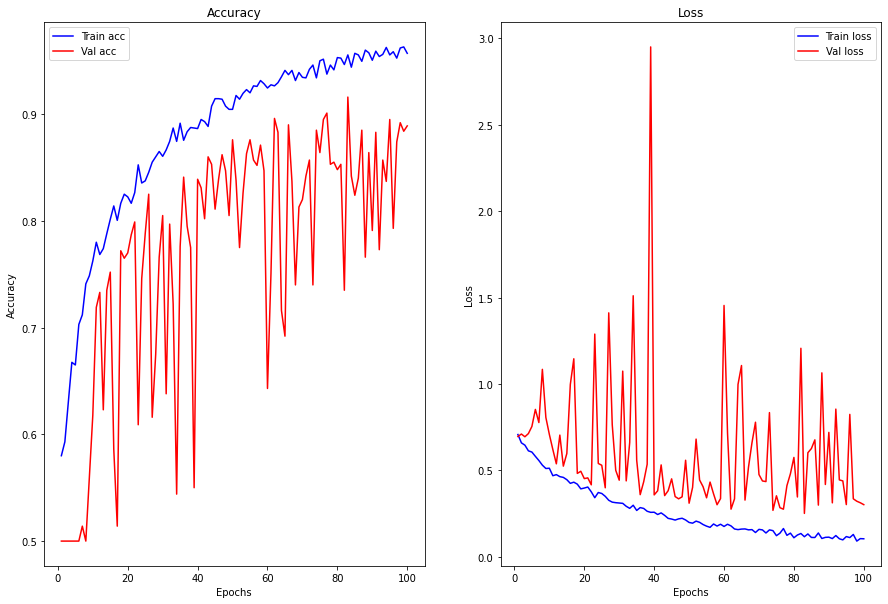

In [14]:
loss = res.history["loss"]
acc = res.history["accuracy"]
val_loss = res.history["val_loss"]
val_acc = res.history["val_accuracy"]

x_range = range(1, len(loss) + 1)

import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.plot(x_range, acc, "b", label="Train acc")
ax1.plot(x_range, val_acc, "r", label="Val acc")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy")
ax1.legend()
ax2.plot(x_range, loss, "b", label="Train loss")
ax2.plot(x_range, val_loss, "r", label="Val loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.set_title("Loss")
plt.show()